<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 5. Composing Plots</h2></div>

So far we have generated plots using [hvPlot](http://hvplot.pyviz.org), but we haven't discussed what exactly these plots are and how they differ from the output of other libraries offering the `.plot` API. It turns out that as in the previous `pn.interact` example, the `.hvplot()` output is actually a rich, compositional object that can be used in many different ways, not just as an immediate plot.  Specifically, hvPlot generates [HoloViews](https://holoviews.org) objects rendered using the [bokeh](https://bokeh.org) backend. In the previous notebook we saw that these objects are rendered as interactive Bokeh plots that support hovering, panning, and zooming. 

In this notebook, we'll examine the output of hvPlot calls to take a look at individual HoloViews objects. Then we will see how these "elements" offer us powerful ways of combining and composing layered visualizations.

### Read in the data

We'll read in the data as before, and also reindex by time so that we can do more easily do resampling. 

In [1]:
import dask.dataframe as dd

In [2]:
df = dd.read_parquet('../../../../holoviz-examples/data/earthquakes.parq')
df.time = df.time.astype('datetime64[ns]')
#df.head()

C:\Users\CRTUCKER\Anaconda3\envs\holoviz\lib\site-packages\fastparquet\dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [3]:
cleaned_df = df.copy()
cleaned_df['mag'] = df.mag.where(df.mag > 0)
cleaned_reindexed_df = cleaned_df.set_index(cleaned_df.time).persist()

### Composing plots
In this section we'll start looking at how we can group plots to gain a deeper understanding of the data. We'll start by resampling the data to explore patterns in number and magnitude of earthquakes over time. 

In [4]:
import hvplot.dask  # noqa: adds hvplot method to dask objects

In [5]:
weekly_count = cleaned_reindexed_df.id.resample('1W').count().rename('count')
weekly_count_plot = weekly_count.hvplot(title='weekly count')

The first thing to note is that with `hvplot`, it is common to grab a handle on the returned output. Unlike the matplotlib based `.plot` API of pandas, where an axis object is returned (with plotting display occuring as a side-effect if matplotlib inline is loaded), grabbing the output of `hvplot` has no side-effects at all (as would be true for typical Python objects as well).

When working with the HoloViews object returned by `hvplot`, plotting only occurs when we look at the object itself:

In [6]:
weekly_count_plot

:Curve   [time]   (count)

Now we have a handle on this object, we can look at its textual representation by printing it:

In [7]:
print(weekly_count_plot)

:Curve   [time]   (count)


This is HoloViews notation for saying that the plot is a `Curve` element with `time` as the key dimension (`kdim`) and `count` as the value dimension (`vdim`). HoloViews will be discussed in more detail in the [next section](./06_Custom_Interactivity.ipynb).

In [8]:
weekly_mean_magnitude = cleaned_reindexed_df.mag.resample('1W').mean()
weekly_mean_magnitude_plot = weekly_mean_magnitude.hvplot(title='weekly mean magnitude')
weekly_mean_magnitude_plot

:Curve   [time]   (mag)

In [9]:
print(weekly_mean_magnitude_plot)

:Curve   [time]   (mag)


This plot has time on the x axis like the other, but the value dimension is magnitude rather than count. Holoviews supports composing plots from individual elements using the `+` symbol to see them side-by-side with linked axes for any shared dimensions:

In [10]:
(weekly_mean_magnitude_plot + weekly_count_plot).cols(1)

:Layout
   .Curve.Mag   :Curve   [time]   (mag)
   .Curve.Count :Curve   [time]   (count)

Try zooming in and out to explore the linking between the plots above.

Interestingly, there are three clear peaks in the monthy counts, and two of them correspond to sudden dips in the mean magnitude, while the third corresponds to a peak in the mean magnitude.

#### Exercise

Use tab completion to explore `weekly_count_plot`. 

<details><summary>Hint</summary><br>

Try accessing .data:

</details>

In [11]:
weekly_count_plot.data.compute()

time  count
0   2000-01-02    372
1   2000-01-09   1248
2   2000-01-16   1406
3   2000-01-23   1441
4   2000-01-30   1310
..         ...    ...
988 2018-12-09   5142
989 2018-12-16   2748
990 2018-12-23   2601
991 2018-12-30   2275
992 2019-01-06    370

[993 rows x 2 columns]

### Adding a third dimension

Now let's filter the earthquakes to only include the really high intensity ones. We can add extra dimensions to the visualization by using color in addition to x and y.

In [12]:
import hvplot.pandas

Here is how you can color by magnitude using pandas `.plot` API:

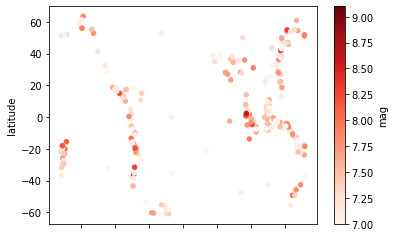

In [13]:
most_severe = df[df.mag >= 7].compute()
%matplotlib inline
most_severe.plot.scatter(x='longitude', y='latitude', c='mag', cmap='Reds')

Here is the analogous version using `hvplot` where we grab the handle `high_mag_scatter` so we can inspect the return value:

In [14]:
high_mag_scatter = most_severe.hvplot.scatter(x='longitude', y='latitude', c='mag', cmap='Reds')
high_mag_scatter

:Scatter   [longitude]   (latitude,mag)

As always, this return value is actually a HoloViews element which has a printed representation:

In [15]:
print(high_mag_scatter)

:Scatter   [longitude]   (latitude,mag)


As mentioned earlier, the notion of a 'scatter' plot implies that there is an *independent variable* and at least one *dependent variable*. This is reflected in the printed representation where the independent variables are in the square brackets and the dependent ones are in parentheses - we can now see that this scatter object implies that latitude is dependent on longitude, which is incorrect. We will learn more about HoloViews objects in the next notebook, and we'll fix the dimensions below.

But first, let's adjust the options to create a better plot. First we'll use [colorcet](https://colorcet.pyviz.org) to get a colormap that doesn't have white at one end, to avoid ambiguity with the page background. We can choose one from the website and use the HoloViews/Bokeh-based colorcet plotting module to make sure it looks good. 

In [16]:
import colorcet as cc

In [17]:
from colorcet.plotting import swatch
swatch('CET_L4')

:Image   [x,y]   (z)

We'll reverse the colors to align dark reds with higher magnitude earthquakes.

In [18]:
mag_cmap = cc.CET_L4[::-1]

In addition to fixing the colormap, we will now switch from `scatter` to using `points` to correctly reflect that longitude and latitude are independent variables, as well as add some additional columns to the hover text, and add a title.

In [19]:
high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag', hover_cols=['place', 'time'],
    cmap=mag_cmap,  title='Earthquakes with magnitude >= 7'
)

high_mag_points

:Points   [longitude,latitude]   (mag,place,time)

When you hover over the points you'll see the place and time of the earthquake in addition to the magnitude and lat/lon. This is reflected in the dimensions that HoloViews is keeping track of:

In [20]:
print(high_mag_points)

:Points   [longitude,latitude]   (mag,place,time)


#### Exercise

Compare this `Points` printed representation to the `Scatter` printed representation and note the differences in how the dimensions are grouped together.

Use the colorcet plotting module `swatches(group='linear')` to choose a different colormap. 


<details><summary>Hint</summary><br>

```python
from colorcet.plotting import swatches
swatches(group='linear')
```

</details>

### Overlay with a tiled map 

That colormap is better, and we can kind of see the outlines of the continents, but the visualization would be much easier to parse if we added a base map underneath. To do this, we'll import a tile element from HoloViews, namely the `OSM` tile from [openstreetmap](https://www.openstreetmap.org/) using the Web Mercator projection: 

In [21]:
from holoviews.element.tiles import OSM
OSM()

:Tiles   [x,y]

Note that when you zoom the map becomes more and more detailed, downloading tiles as necessary. In order to overlay on this basemap, we need to project our earthquakes to the Web Mercator projection system.

In [22]:
import numpy as np
import pandas as pd

from datashader.utils import lnglat_to_meters

To do this we will use the `lnglat_to_meters` function in the `datashader.geo` module to map `longitude` and `latitude` to `easting` and `northing` respectively:

In [23]:
x, y = lnglat_to_meters(most_severe.longitude, most_severe.latitude)
most_severe_projected = most_severe.join([pd.DataFrame({'easting': x}), pd.DataFrame({'northing': y})])

We can now overlay our points on top of the `OSM` tile source but instead of overlaying the tile source explicitly we can also just specify `tiles='OSM'` as a string:

In [24]:
most_severe_projected.hvplot.points(
    x='easting', y='northing', c='mag', hover_cols=['place', 'time'], 
    cmap=mag_cmap, title='Earthquakes with magnitude >= 7', tiles='OSM',
    line_color='black'
)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [easting,northing]   (mag,place,time)

Note that the Web Mercator projection is only one of many possible projections used when working with geospatial data. If you need to work with these different projections, you can use the [GeoViews](http://geoviews.org) extension to HoloViews that makes elements aware of the projection they are defined in and automatically projects into whatever coordinates are needed for display. 


#### Exercise

Import and use different tiles. 


<details><summary>Hint</summary><br>

EsriImagery or Wikipedia.

</details>


### Overlay with a raster
That base map is helpful for orienting ourselves, but it isn't really adding too much new information. We might instead like to overlay the earthquakes on a map of global population. We'll start by reading in a raster of global population, to see how the events might affect people. We'll use [xarray](https://xarray.pydata.org) to load this multidimensional raster data file, as such formats are not handled well by Pandas:

In [25]:
import xarray as xr
import hvplot.xarray  # noqa: adds hvplot method to xarray objects

In [26]:
ds = xr.open_dataarray('../../../../holoviz-examples/data/gpw_v4_population_density_rev11_2010_2pt5_min.nc')
ds

<xarray.DataArray (band: 1, y: 4320, x: 8640)>
[37324800 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
Attributes:
    transform:   [ 4.16666667e-02  0.00000000e+00 -1.80000000e+02  0.00000000...
    crs:         EPSG:4326
    res:         [0.04166667 0.04166667]
    is_tiled:    0
    nodatavals:  -3.4028230607370965e+38

In [27]:
cleaned_ds = ds.where(ds.values != ds.nodatavals).sel(band=1)
cleaned_ds.name = 'population'

The `xarray.plot()` API is fine for plotting small sections of this dataset, but it doesn't do well with the full resolution. For that it is better to use `hvplot` to take advantage of datashading. Here we are plotting Indonesia.

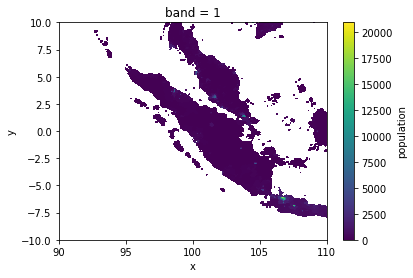

In [28]:
ROI = cleaned_ds.sel(y=slice(10, -10), x=slice(90, 110))
ROI.plot()

To make out more detail we will apply a logarithmic colormap and set a `clim` to exclude the lower bound of zero:

In [29]:
rasterized_pop = cleaned_ds.hvplot.image(rasterize=True, logz=True, clim=(1, np.nan), height=400)
rasterized_pop

:DynamicMap   []
   :Image   [x,y]   (population)

By inspecting the HoloViews object, we can see that the output isn't actually an Image, instead it is a DynamicMap. This means that the image that is displayed is actually just one of many images that are computed on the fly (dynamically), as you can see when you zoom in.

In [30]:
print(rasterized_pop)

:DynamicMap   []
   :Image   [x,y]   (population)


#### Exercise

Use `.last` to inspect the last image from the `DynamicMap`. Zoom into the plot above and inspect `.last` again.

In [31]:
rasterized_pop.last

:Image   [x,y]   (population)

### Putting it together

Now we can clean up the styling on this map because the color scale and the color map make it very hard to see what's going on. We'll also overlay this with the earthquakes.

In [32]:
title = 'High magnitude (>=7) earthquakes over population density [people/km^2] from 2000 to 2019'
rasterized_pop = cleaned_ds.hvplot.image(
    rasterize=True, cmap='kbc', logz=True, clim=(1, np.nan),
    height=600, width=1000, xaxis=None, yaxis=None
)
high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag',
    hover_cols=['place', 'time'], cmap=mag_cmap).opts(bgcolor='black')

pop_and_high_mag = (rasterized_pop * high_mag_points).relabel(title)
pop_and_high_mag 

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (population)
      .Points.I :Points   [longitude,latitude]   (mag,place,time)

In [33]:
print(pop_and_high_mag)

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (population)
      .Points.I :Points   [longitude,latitude]   (mag,place,time)


As you can see, the HoloViews objects returned by hvPlot are in no way dead ends -- you can flexibly compare, combine, lay out, and overlay them to reveal complex interrelationships in your data.

In the next notebook we'll learn how to flexibly customize how HoloViews plots interact with each other, to show such relationships on the fly.